In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt

In [4]:

#created variales for images size
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/NEWmangoDATASET/diseasemango",
shuffle =True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size= BATCH_SIZE
)

Found 2995 files belonging to 7 classes.


In [7]:
class_names=dataset.class_names
class_names

['Bacterial_Canker',
 'Healthy  leaf',
 'Healthy leaf',
 'Sooty Mould  Leaf',
 'Sooty Mould leaf',
 'anthracnose  leaf',
 'anthracnose leaf']

In [8]:
len(dataset)

94

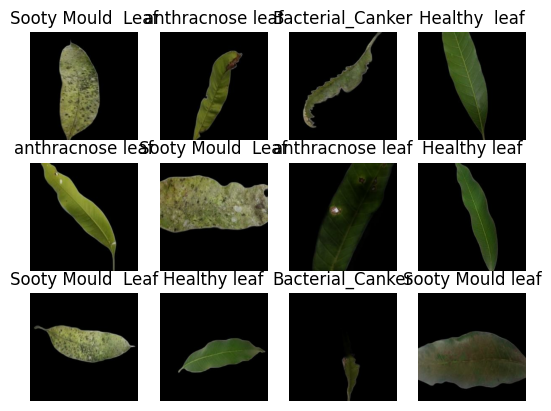

In [9]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        #to turn off the axis points
        plt.axis("off")
        
    

In [10]:
#SPLITTING DATASET
#80 for training
# 20 for validation
#10 for tetsing
train_size=0.8
len(dataset)*train_size


75.2

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

40

In [13]:
val_size=0.1
len(dataset)*val_size

9.4

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

34

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

75

In [19]:
len(val_ds)

9

In [20]:
len(test_ds)

10

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
#Data Augmentation
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
75/75 [==============================] - 717s 388ms/step - loss: 1.7745 - accuracy: 0.2928 - val_loss: 1.4121 - val_accuracy: 0.4792
Epoch 2/25
75/75 [==============================] - 24s 321ms/step - loss: 1.2428 - accuracy: 0.5052 - val_loss: 1.5356 - val_accuracy: 0.3854
Epoch 3/25
75/75 [==============================] - 24s 314ms/step - loss: 1.0029 - accuracy: 0.6083 - val_loss: 0.9211 - val_accuracy: 0.6632
Epoch 4/25
75/75 [==============================] - 23s 309ms/step - loss: 0.7950 - accuracy: 0.7047 - val_loss: 0.9480 - val_accuracy: 0.6701
Epoch 5/25
75/75 [==============================] - 24s 321ms/step - loss: 0.6523 - accuracy: 0.7583 - val_loss: 0.5869 - val_accuracy: 0.8021
Epoch 6/25
75/75 [==============================] - 24s 315ms/step - loss: 0.5524 - accuracy: 0.7935 - val_loss: 0.7301 - val_accuracy: 0.6910
Epoch 7/25
75/75 [==============================] - 23s 310ms/step - loss: 0.4458 - accuracy: 0.8345 - val_loss: 0.4308 - val_accuracy: 0.861

In [29]:
model.save("/content/drive/MyDrive/NEWmangoDATASET/mdseg_model_256_32.h5")

In [30]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 7s 30ms/step - loss: 0.3089 - accuracy: 0.8875


In [31]:
scores

[0.30892419815063477, 0.887499988079071]

In [32]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 75}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

25

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.7745167016983032,
 1.2427674531936646,
 1.0028585195541382,
 0.7949916124343872,
 0.6522896885871887]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

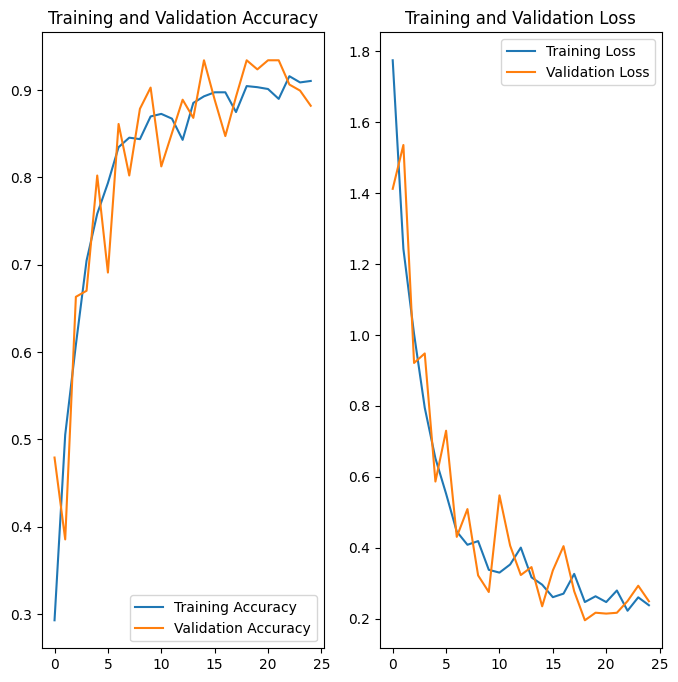

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: anthracnose  leaf
1/1 [==============================] - 0s 218ms/step
predicted label: Bacterial_Canker


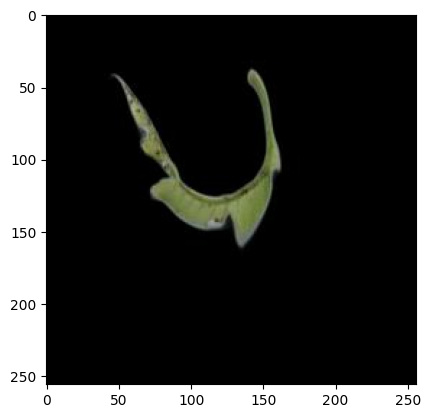

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


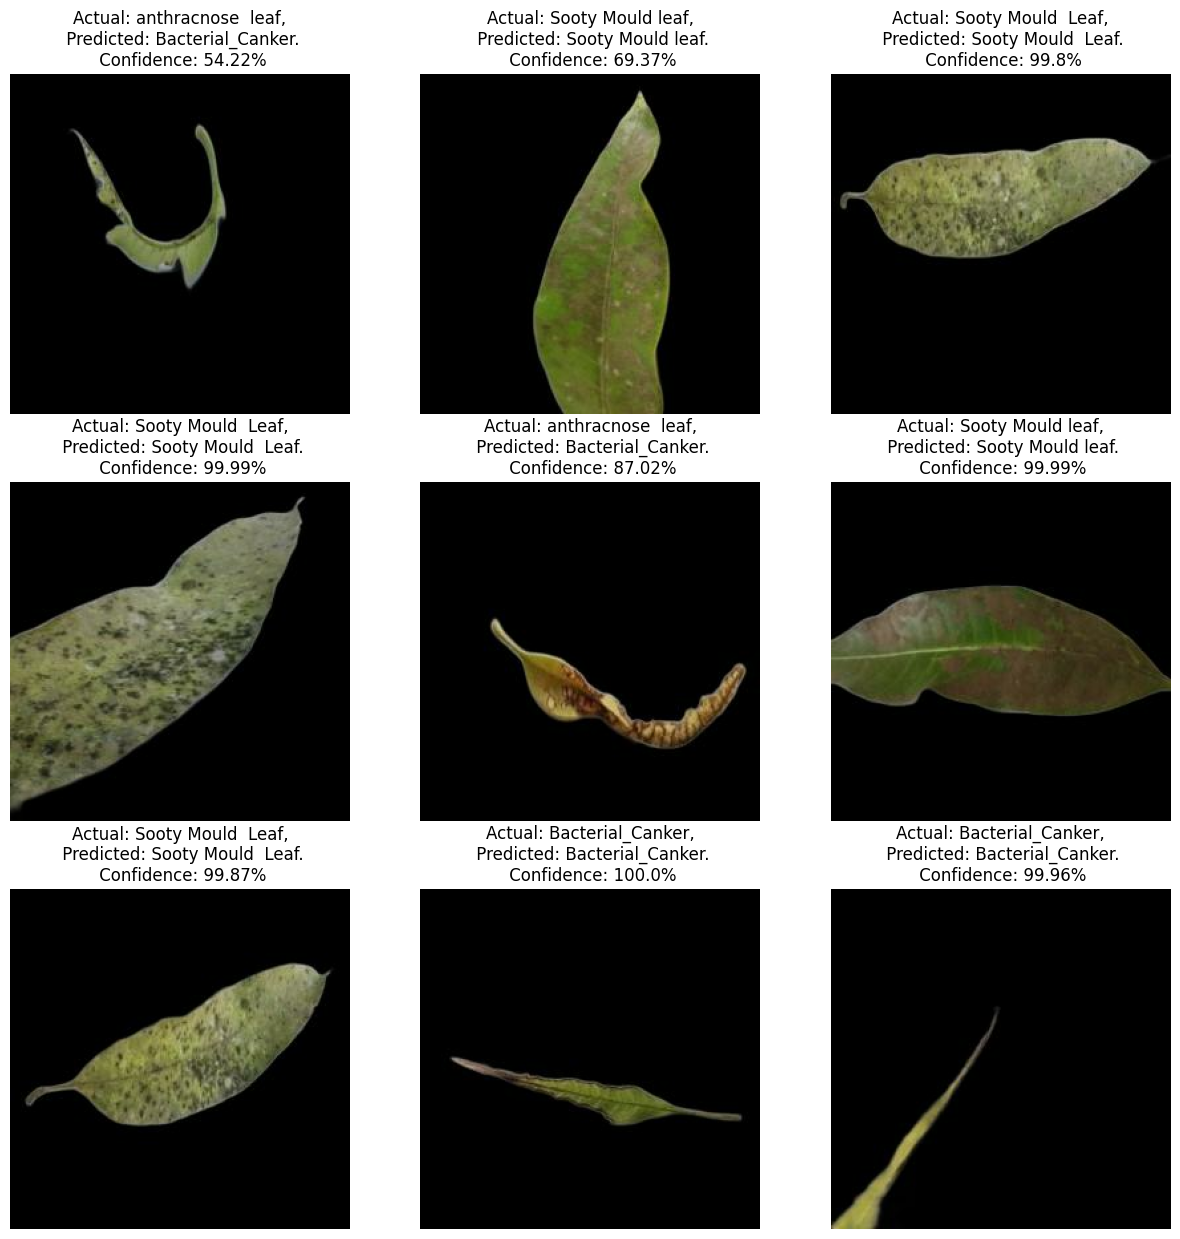

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("/content/drive/MyDrive/NEWmangoDATASET/saved_model256256.h5")
